In this project, we can adopt the concept of quantum to encode the chrome of genetic algorithms. Suppose we are going to explore a continual space for several variables in order to get a maximal value for the object function.
$$f(x, y) = 10cos(2 \pi x) \ + 10sin(2\ pi y) - x^2 - y^2 + 25$$

In [183]:
import numpy as np
import queue
from time import ctime,sleep
from matplotlib import pyplot as plt
%matplotlib inline
x = np.linspace(-1, 1, num=50)
y= np.linspace(-1, 1, num=50)

In [184]:
def objFunc(x, y):
    return 10*np.cos(2*np.pi*x) + 10*np.sin(2*np.pi*y) - x**2 - y**2 + 25

In [185]:
objFunc(0, 0.25)

44.9375

## Make 3D plot

We can visualize the values of the function along both the axes of x and y, here we suppose the range of x, y is (-1, 1).

In [186]:
#Calculate the grid
u, v = np.meshgrid(x, y)
f = objFunc(u, v)

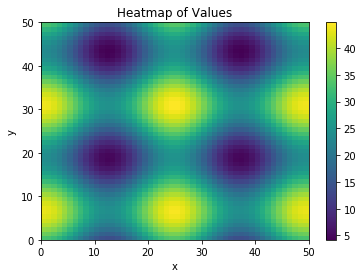

In [190]:
#Make a heatmap
plt.pcolor(f)
plt.colorbar()
plt.title('Heatmap of Values')
plt.xlabel('x')
plt.ylabel('y')

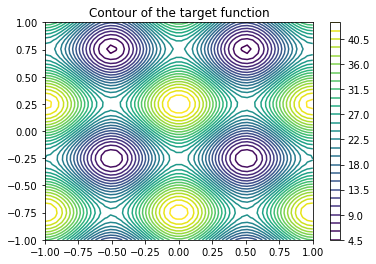

In [191]:
plt.contour(u, v, f, 30)
plt.colorbar()
plt.title('Contour of the target function')

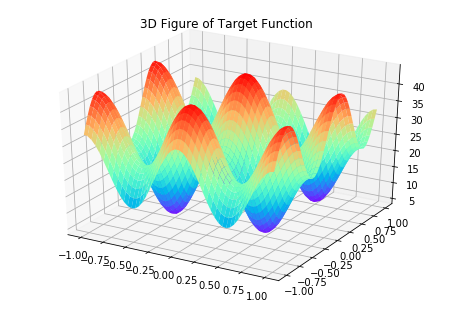

In [192]:
from mpl_toolkits.mplot3d import Axes3D
figure = plt.figure()
ax = Axes3D(figure)
ax.plot_surface(u, v, f, rstride=1, cstride=1, cmap='rainbow')
plt.title('3D Figure of Target Function')

It is very clear that this function has several local maximal points, however the largets lies around(0, 0.25). It is not easy to leverage gradient descending methods to get the optimal values. Alternatively, we can use quantum algorithm to search for the optimal values.

## Quantum Genetic Algorithm

First we need to discuss the differences between conventional genetic algorithm and quantum genetic algorithm. 
For Conventional Genetic Algorithm:
- To represent each parameter combination as a series of chromosome, each parameter is encoding as a series of 0 or 1.
- The classic procedures are generating population, selection, crossover and mutation.
- It is through crossover and mutation to update the population.

For Quantum Genetic Algorithm:
- To represent each parameter as a series of qubit which is determined by $\alpha$ and $\beta$, and the parameter combination as a chromosome of series of qubit.
- The procedures are genetating population, quantum rotation gating, NOT gating.
- It is through quantum rotation gating, NOT gating to update the population.

In [163]:
def encodingParameter(param_count=2, bit_len=10):
    '''
    Qubit encoding for parameters
    ArgsL
    param_count: number of parameters
    bit_len: bit length for each parameter
    '''
    degrees = np.pi/4 * np.ones((param_count, bit_len))
    chromosome = dict()
    chromosome['sin'] = np.sin(degrees)
    chromosome['cos'] = np.cos(degrees)
    chromosome['degree'] = degrees
    return chromosome

In [164]:
class individual:
    def __init__(self, chromosome):
        '''
        Args:
        chromosome: quantum qubit of genes, dictionary , ['sin':..,'cos':...,'degree':...]
        there's a dictinary within each list, including alpha, beta and angles
        '''
        self.chromosome = chromosome
        
    def collapse(self):
        '''
        Collapse a qubit into a state like [0 1 1 0]
        '''
        alpha = self.chromosome['sin']
        beta = self.chromosome['cos']
        pick = np.random.uniform(0, 1, alpha.shape)
        states = np.where(pick >= alpha**2, 1, 0)
        return states
    
    def bin2decimal(self, state, bound=1):
        '''
        Map a binary state into a decimal value
        '''
        shape = state.shape
        bit_len = shape[-1]
        base = np.array([2**l for l in np.arange(bit_len)])
        values = np.dot(state, base)
        values = -bound + values/(2**bit_len-1)*2*bound
        return values
        
        
    def calFunc(self, variables):
        '''
        Calculate fitness for a given parameter combination
        '''
        x = variables[0]
        y = variables[1]
        #f = x**2 + y**2 - x - y
        f = 10*np.cos(2*np.pi*x) + 10*np.sin(2*np.pi*y) - x**2 - y**2
        return f
    
    def calFitness(self, f):
        '''
        Transform the value into a non-negative fitness
        '''
        return f + 25
    
    def proceed(self):
        states = self.collapse()
        values = self.bin2decimal(states)
        self.func = self.calFunc(values)
        self.fitness = self.calFitness(self.func)
        self.states = states
        self.values = values
        

In [165]:
chromosome = encodingParameter()
chromosome

{'cos': array([[ 0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
          0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
          0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678]]),
 'degree': array([[ 0.78539816,  0.78539816,  0.78539816,  0.78539816,  0.78539816,
          0.78539816,  0.78539816,  0.78539816,  0.78539816,  0.78539816],
        [ 0.78539816,  0.78539816,  0.78539816,  0.78539816,  0.78539816,
          0.78539816,  0.78539816,  0.78539816,  0.78539816,  0.78539816]]),
 'sin': array([[ 0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
          0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
          0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678]])}

In [166]:
obj = individual(chromosome)
obj.proceed()

In [167]:
obj.func

0.95739017492547063

In [175]:
class createPopulation:
    def __init__(self, pop_size=200):
        self.pop_size = pop_size
        
    def __initializeChromosome(self, param_count=2, bit_len=10):
        '''
        Qubit encoding for parameters
        Args:
        param_count: number of parameters
        bit_len: bit length for each parameter
        '''
        degrees = np.pi/4 * np.ones((param_count, bit_len))
        chromosome = dict()
        chromosome['sin'] = np.sin(degrees)
        chromosome['cos'] = np.cos(degrees)
        chromosome['degree'] = degrees
        return chromosome
    
    def generatePop(self):
        population = []
        for _ in np.arange(self.pop_size):
            chromosome = self.__initializeChromosome()
            obj = individual(chromosome)
            obj.proceed()
            population.append(obj)
        return population

In [176]:
pop = createPopulation(500)
population = pop.generatePop()

In [179]:
class QuantumGeneticAlgorithm:
    def __init__(self, population):
        '''
        Initialize genetic algorithm
        '''
        self.population = population
        self.pop_size = len(population)
        
    def rotationAngleDirection(self, bestIndividual, obj):
        '''
        Calculate rotation angles and directions for each individual
        '''
        #Initialize the shift angle
        delta_theta = 0.01 * np.pi
        #Compare the fitness
        fitness_flag = obj.fitness > bestIndividual.fitness
        #Traverse each weight layer
        alpha = obj.chromosome['sin']
        #beta size: layer(i), layer(i+1), bit length
        beta = obj.chromosome['cos']
        #Original angles:
        degrees = obj.chromosome['degree']
        #state size: layer(i), layer(i+1), bit length
        #state, e.g [0 1 1 0]
        bit = obj.states
        #Traverse each parameter
        best_bit = bestIndividual.states
        #Search the table
        criteria = (bit + best_bit) == 1
        #Calculate shift angles for each parameter
        delta = criteria * delta_theta
        #Calculate the sign of shift angles
        sgns = np.zeros(bit.shape)#Initialize it with zeros
        #Try to avoid loops, use matrix operation as much as mossible
        #IF xi=0 besti=1, then the difference will be -1
        current_best_bit_flag = bit - best_bit
        #Create a matrix of fitness flag with the same shape as the weight
        fitness_flags = np.ones(bit.shape) * fitness_flag
        #Map 0 into -1
        fitness_flags = np.where(fitness_flags>0, 1, -1)
        alpha_beta_pos = (alpha * beta) > 0
        alpha_beta_neg = (alpha * beta) < 0
        alpha_zero = alpha == 0
        beta_zero = beta == 0
        #if alpha * beta>0
        sgns += current_best_bit_flag * fitness_flags * alpha_beta_pos
        #if alpha * beta<0
        sgns += (-1)*current_best_bit_flag * fitness_flags * alpha_beta_neg
        #if alpha = 0
        #Gnerate +1 -1 at random
        direction = np.random.choice([1, -1], size=bit.shape)
        criteria = current_best_bit_flag * fitness_flags * alpha_zero < 0
        sgns += criteria * direction
        #if beta = 0
        criteria = current_best_bit_flag * fitness_flags * beta_zero > 0
        sgns += criteria * direction
        #Calculate shift angles
        angles = delta * sgns
        #Calculate new angles
        degrees = degrees - angles
        obj.chromosome['sin'] = np.sin(degrees)
        obj.chromosome['cos'] = np.cos(degrees)
        obj.chromosome['degree'] = degrees
        obj.proceed()
        return obj
    
    def rotatingGates(self, bestIndividual_index):
        '''
        Rotate gates of quantum registra,
        Note, we try to make use of numpy's matrix operations to speed
        Computation
        Args:
        bestIndividual_index: the index of the best individual
        '''
        bestIndividual = self.population[bestIndividual_index]
        #q = queue.queue()
        #Traverse each individual
        indices = [bestIndividual] * self.pop_size
        self.population = list(map(self.rotationAngleDirection, indices, self.population))
        #for i in np.arange(self.pop_size):
            #obj = self.population[i]
            #obj = self.rotationAngleDirection(bestIndividual, obj)
            #self.population[i] = obj
            
    def NotGates(self, ratio=0.05):
        '''
        Rotate gates of quantum registra,
        Note, we try to make use of numpy's matrix operations to speed
        Computation
        Args:
        bestIndividual_index: the index of the best individual
        '''
        #Traverse each individual
        num = int(self.pop_size * ratio)
        indice = np.random.choice(self.pop_size, num)
        for i in indice:
            obj = self.population[i]
            obj = self.mutation(obj)
            self.population[i] = obj
            
    def mutation(self, obj):
        '''
        Mutation at several random point within an individual
        '''
        #Traverse each parameter in this layer
        #qubit contains alpha and beta
        #Alpha size: layer(i), layer(i+1), bit length
        #A qubit is a pair of alpha and beta
        alpha = obj.chromosome['sin']
        #beta size: layer(i), layer(i+1), bit length
        beta = obj.chromosome['cos']
        #Degrees
        degrees = obj.chromosome['degree']
        picks = np.random.uniform(0, 1, size=degrees.shape)
        #state size: layer(i), layer(i+1), bit length
        alpha_flag = alpha < picks
        beta_flag = beta < picks
        degrees = degrees - alpha_flag*beta_flag*np.pi/2
        obj.chromosome['sin'] = np.sin(degrees)
        obj.chromosome['cos'] = np.cos(degrees)
        obj.chromosome['degree'] = degrees
        obj.proceed()
        return obj
    
    def proceed(self, generation_num = 1):
        '''
        Execute quantum rotation and not gating
        '''
        #Keep the best individual
        best_fitness, optimal_index, _ = self.findMaximalIndividual()
        best_individual = self.population[optimal_index]
        for i in np.arange(generation_num):
            #Quantum Rotation Gate
            if i%10 == 0:
                print('Best Fitness:', round(best_fitness, 4))
            self.rotatingGates(optimal_index)
            #Mutation
            self.NotGates()
            fitness, max_index, min_index = ga.findMaximalIndividual()
            if fitness < best_fitness:
                self.population[min_index] = best_individual
            else:
                best_fitness = fitness
                optimal_index = max_index
                best_individual = self.population[optimal_index]
        return best_individual
        
    def findMaximalIndividual(self):
        funcs = np.array([one.func for one in self.population])
        fitnesses = np.array([one.fitness for one in self.population])
        optimal_value = max(fitnesses)
        optimal_index = fitnesses.argmax()
        minimal_index = fitnesses.argmin()
        return optimal_value, optimal_index, minimal_index

In [181]:
ga = QuantumGeneticAlgorithm(population)
best = ga.proceed(300)

Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364
Best Fitness: 44.9364


In [182]:
best.values

array([ 0.00097752,  0.2512219 ])

It seems the algorithm can approach the ideal point after generations of search.